This notebook shows further performance evaluation of our CheXNet-based model as well as the attempt to use GradCAM for model explainability. We first load some necessary libraries.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
import os
import random

Checking GPU Access

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Loading the Dataset

In [2]:
dir_data = '/project/dsc-is/napi/dat0/'

if not "data_all" in globals():
    tmp = np.load(os.path.join(dir_data, 'pix_w256_1.npz'))
    data1 = tmp['arr_0']
    print(data1.shape)
    tmp = np.load(os.path.join(dir_data, 'pix_w256_2.npz'))
    data2 = tmp['arr_0']
    print(data2.shape)
    
    data_all = np.concatenate((data1,data2), axis=0).reshape((-1,256,256,1)) # tensorflow is channels last
    del data1
    del data2

print(data_all.shape)

(50297, 256, 256)
(32700, 256, 256)
(82997, 256, 256, 1)


Getting the Diagnosis

In [3]:
diagnosis1 = pd.read_csv(os.path.join(dir_data, 'diagnosis_new.txt'), sep='\t', header=None)
yyy_scoliosis = (diagnosis1.iloc[:,4]=="有").to_numpy().astype(int)

Loading our model

In [4]:
model = keras.models.load_model("chexnet_transfer_learning_gpu_unfreezed.h5")

We then store all of our model predictions in an npy file.

In [5]:
def transform_image(image):
  image = tf.broadcast_to(tf.convert_to_tensor(image / 255), [1, 256, 256, 3])
  return image

In [6]:
'''
preds = np.empty(shape = (yyy_scoliosis.shape[0], 2))
for i in range(yyy_scoliosis.shape[0]):
    pred = model.predict(transform_image(data_all[i]))[0][0] 
    preds[i,0] = pred
    preds[i,1] = int(pred >= 0.5)

np.save('preds.npy', preds)
'''

preds = np.load('preds.npy')

Given the model predictions and the ground truth labels, we identify the indices of the true positives, false positives, true negatives, and false negatives.

In [7]:
true_positives = np.asarray(np.logical_and(preds[:,1] == 1, yyy_scoliosis == 1)).nonzero()[0]
false_positives = np.asarray(np.logical_and(preds[:,1] == 1, yyy_scoliosis == 0)).nonzero()[0]
true_negatives = np.asarray(np.logical_and(preds[:,1] == 0, yyy_scoliosis == 0)).nonzero()[0]
false_negatives = np.asarray(np.logical_and(preds[:,1] == 0, yyy_scoliosis == 1)).nonzero()[0]

We then construct the confusion matrix.

In [28]:
confusion_matrix = pd.DataFrame(columns = ['Positive Diagnosis', 'Negative Diagnosis', 'Totals'], 
                                index = ['Positive Prediction', 'Negative Prediction', 'Totals'],
                                data = [[true_positives.shape[0], false_positives.shape[0], true_positives.shape[0] + false_positives.shape[0]],
                                        [false_negatives.shape[0], true_negatives.shape[0], false_negatives.shape[0] + true_negatives.shape[0]],
                                        [true_positives.shape[0] + false_negatives.shape[0], false_positives.shape[0] + true_negatives.shape[0], 82997]])
confusion_matrix

Positive Diagnosis  Negative Diagnosis  Totals
Positive Prediction                1178                 306    1484
Negative Prediction                 130               81383   81513
Totals                             1308               81689   82997

We then compute for the usual classification metrics. As seen below, our model seems to perform quite well, achieving a relatively high accuracy and ROC-AUC score. 

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f'Accuracy: {round(100*accuracy_score(yyy_scoliosis, preds[:,1]),3)}%')
print(f'Precision: {round(100*precision_score(yyy_scoliosis, preds[:,1]),3)}%')
print(f'Recall: {round(100*recall_score(yyy_scoliosis, preds[:,1]),3)}%')
print(f'F1-Score: {round(100*f1_score(yyy_scoliosis, preds[:,1]),3)}%')
print(f'ROC_AUC: {round(100*roc_auc_score(yyy_scoliosis, preds[:,0]),3)}%')

Accuracy: 99.475%
Precision: 79.38%
Recall: 90.061%
F1-Score: 84.384%
ROC_AUC: 99.138%


We now proceed in implementing GradCAM. We first get a summary of the CheXNet-based portion of our model, so that we can see which layers are of interest.

In [18]:
model.layers[1].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

We first create a function that outputs a heatmap based on the weights and gradients of a given layer.

In [292]:
def make_gradcam_heatmap(image, conv_layer = 'relu', next_layer = 'avg_pool'): # expected image shape is (256, 256, 1)
    image = transform_image(image)
    layer1 = model.layers[0]
    x = layer1(image)
    layer2 = model.layers[1]
    layer2_last_conv = keras.Model(inputs = layer2.inputs, outputs = layer2.get_layer(conv_layer).output)
    with tf.GradientTape() as tape:
        last_conv_output = layer2_last_conv(x) 
        layer2_top = keras.Model(inputs = layer2.get_layer(next_layer).input, outputs = layer2.output)
        layer2_output = layer2_top(last_conv_output)
        layer3 = model.layers[-1]
        pred = layer3(layer2_output)
    grads = tape.gradient(pred, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

The function below will then superimpose a resized heatmap to our original image, allowing us to see regions of importance in our X-ray images.

In [293]:
def display_gradcam(image, alpha=0.8, return_numpy = True, conv_layer = 'relu', next_layer = 'avg_pool'):
    heatmap = make_gradcam_heatmap(image, conv_layer = conv_layer, next_layer = next_layer)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    image = np.broadcast_to(image, (256, 256, 3))
    superimposed_img = jet_heatmap * alpha + image * 1
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    if return_numpy:
        return np.array(superimposed_img)
    else:
        return superimposed_img

Finally, the function below displays a random sample of 5 images with their GradCAM heatmaps.

In [294]:
def random_cam_show(indices, title = None, conv_layer = 'relu', next_layer = 'avg_pool'):
    sampling = random.sample(indices, 5)
    
    fig, ax = plt.subplots(ncols = 5, sharex = True, sharey = True, figsize = (25, 5), constrained_layout = True)
    plt.setp(ax, xticks=[], yticks=[])
    if title is not None:
        fig.suptitle(f"{title}", fontsize = 25)
    for i in range(5):
        ax[i].imshow(display_gradcam(data_all[sampling[i]], conv_layer = conv_layer, next_layer = next_layer))
    plt.show()

Finally, we then display the images with superimposed GradCAM heatmaps of the true positives, false positives, true negatives, and false positives.

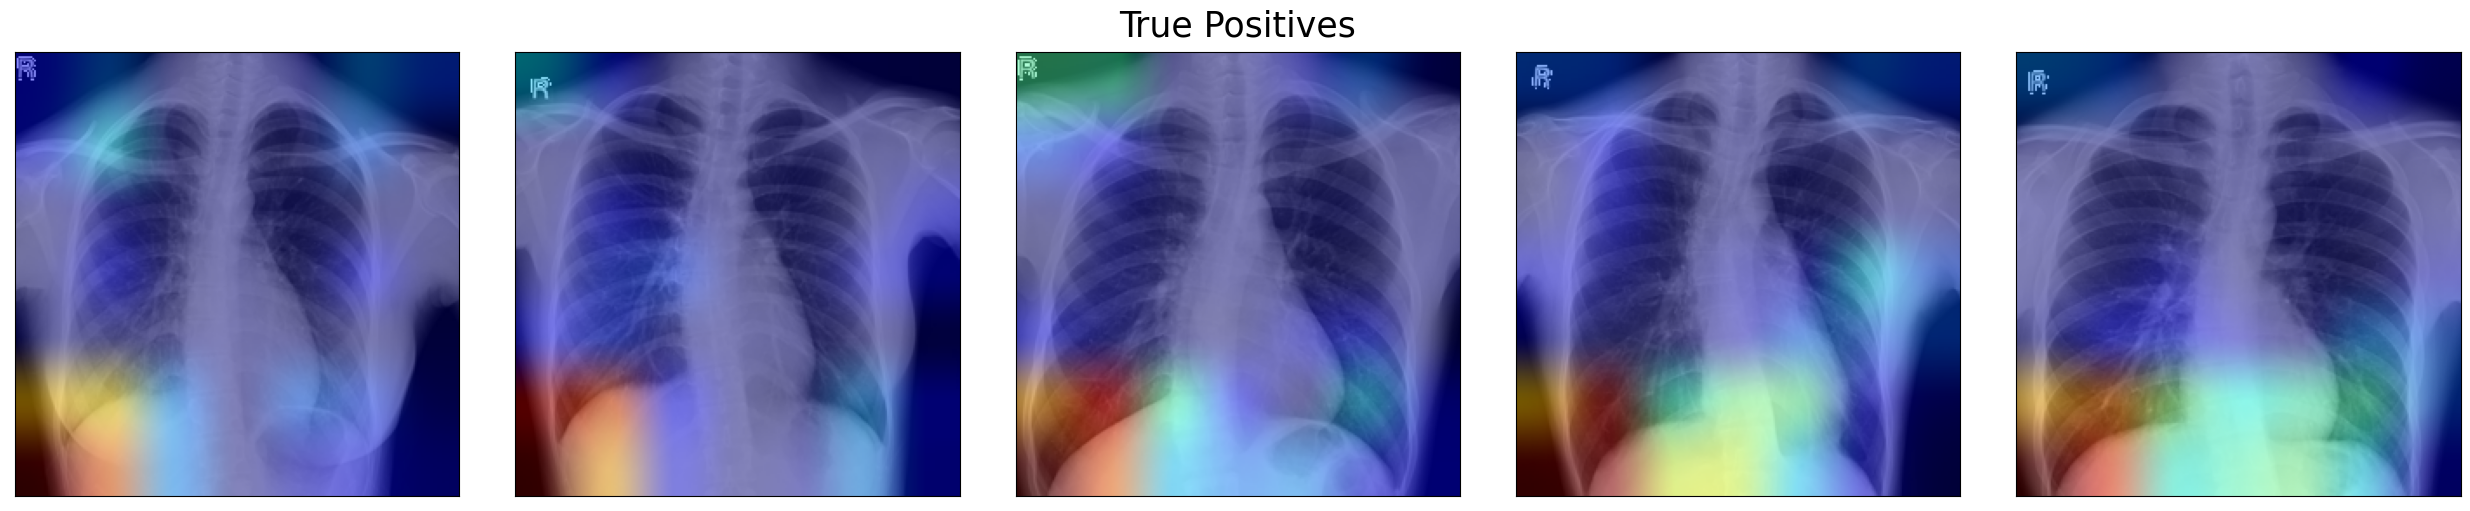

In [314]:
random_cam_show(list(true_positives), title = 'True Positives')

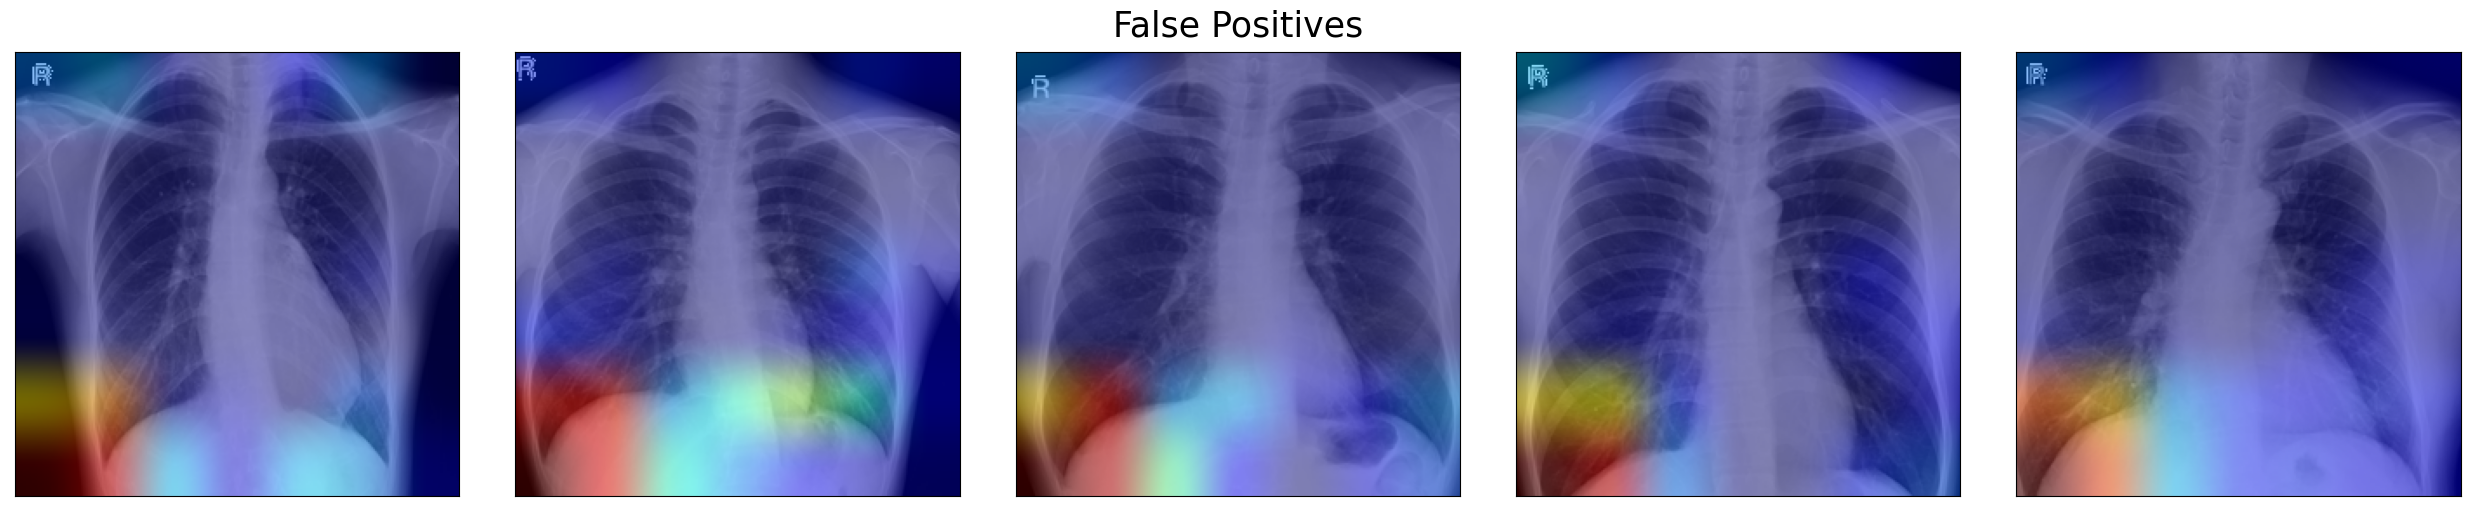

In [313]:
random_cam_show(list(false_positives), title = 'False Positives')

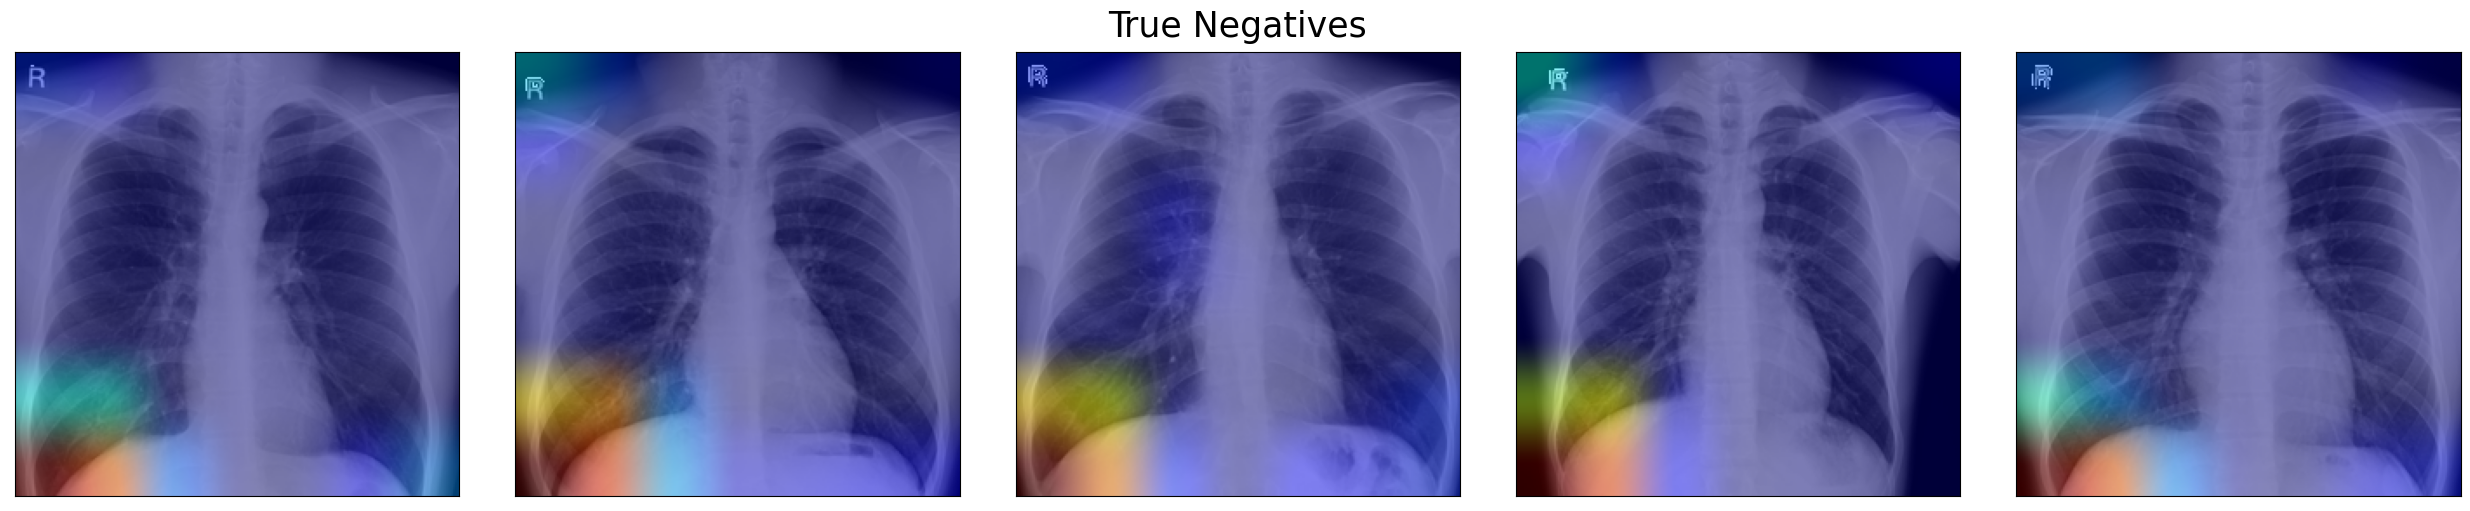

In [312]:
random_cam_show(list(true_negatives), title = 'True Negatives')

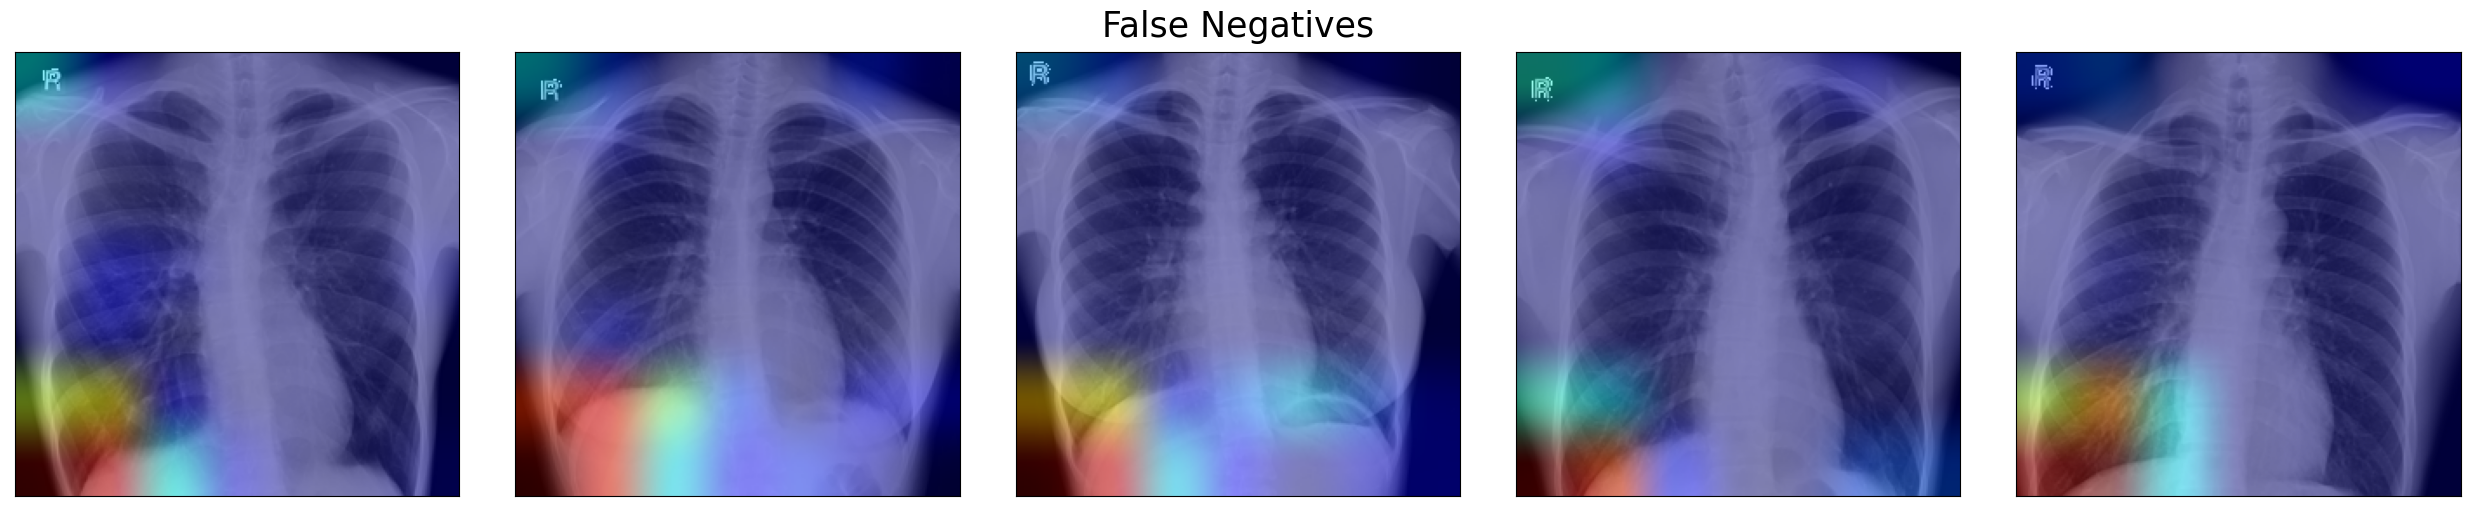

In [310]:
random_cam_show(list(false_negatives), title = 'False Negatives')

As seen above, the activations seem to be focused on the lower left of the images regardless of what class they belong. I am not sure whether these are accurate or if there is an error in my implementation. Further investigation could have been done but due to time constraints (limited internship duration), I was unable to further look into this.